In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random

SEED = 0

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed=SEED) # Setting seed for a reproducible code.

## Aluminium Historical Data

In [2]:
# Loading the relevant columns of the dataset.

df = pd.read_csv('Aluminium Historical Data_2012.csv', index_col = ['Date'], parse_dates=['Date'])
df = df['Price']
df = df.str.replace(',','').astype(float)
df = df.iloc[::-1]
df.dtypes

dtype('float64')

In [3]:
df

Date
2014-06-16    1840.25
2014-06-17    1852.00
2014-06-18    1874.50
2014-06-19    1890.50
2014-06-20    1888.50
               ...   
2022-06-16    2504.50
2022-06-17    2498.00
2022-06-20    2527.00
2022-06-21    2533.50
2022-06-22    2528.00
Name: Price, Length: 2028, dtype: float64

In [4]:
df.describe()

count    2028.000000
mean     1989.368787
std       416.875708
min      1435.750000
25%      1726.187500
50%      1888.250000
75%      2104.500000
max      3849.000000
Name: Price, dtype: float64

Text(0.5, 1.0, 'Aluminium Historical Data')

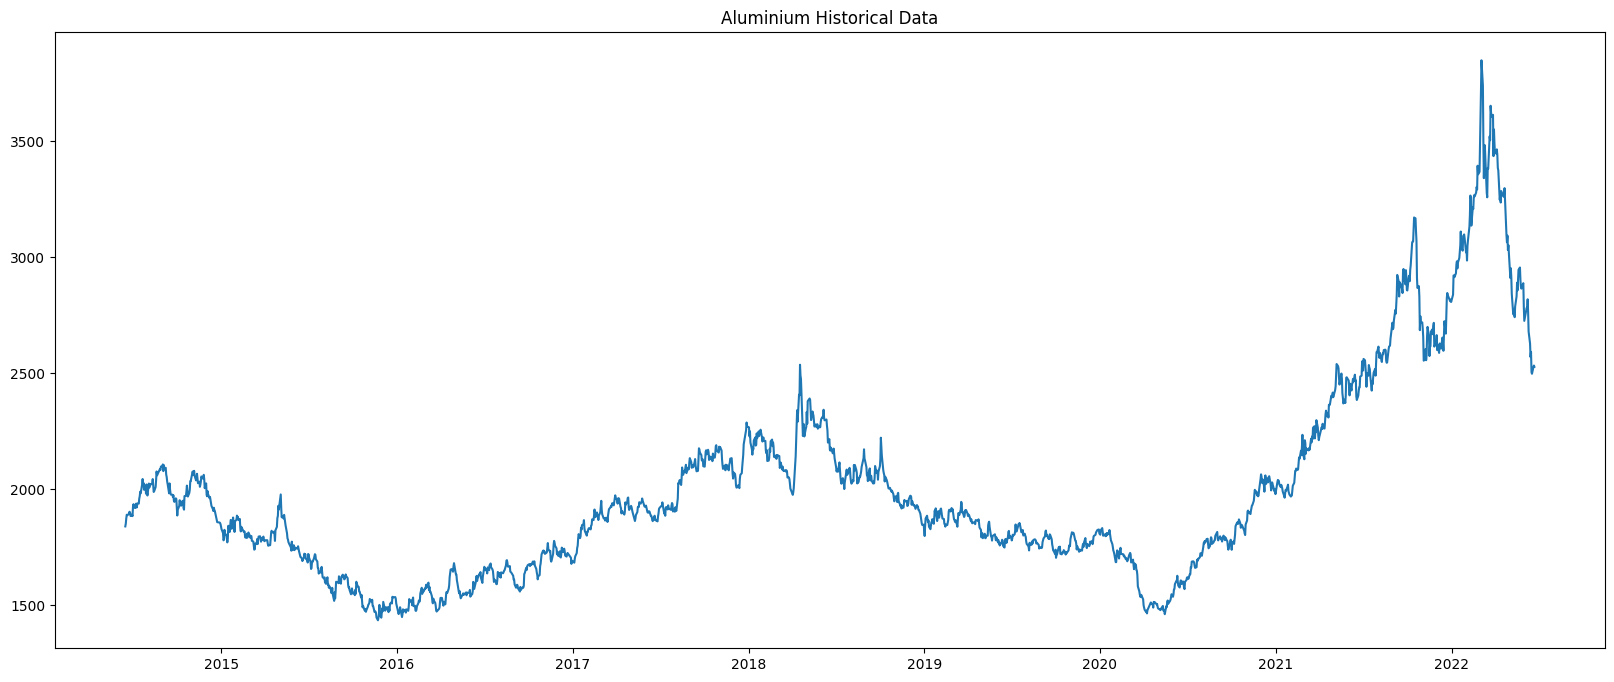

In [5]:
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(df)
plt.title(f'Aluminium Historical Data')

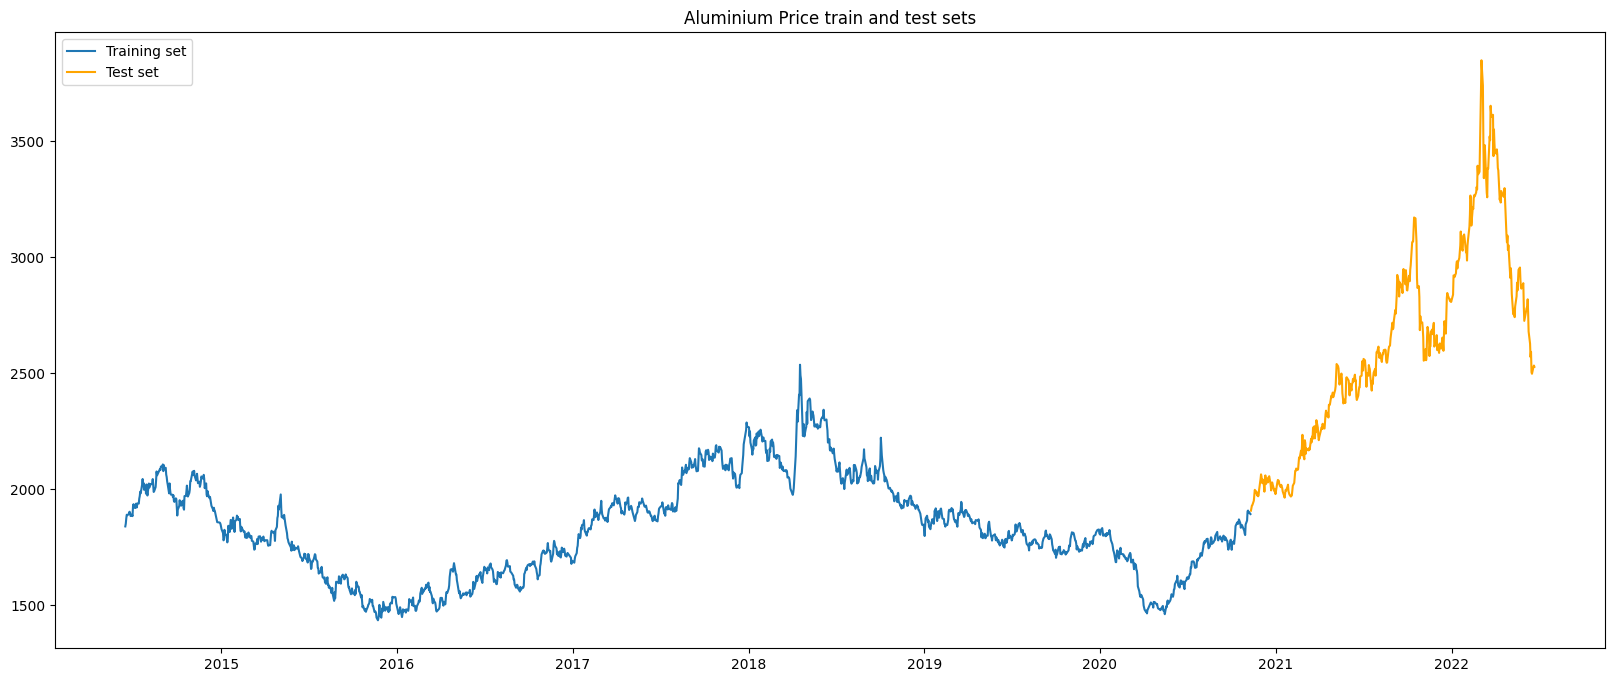

In [6]:
# Lets see how it would be split using 20% of data to test
 
test_size = int(round(df.shape[0]*0.2))

df_train = df[:-test_size]
df_test = df[-test_size:]

plt.title('Aluminium Price train and test sets')
plt.plot(df_train, label='Training set')
plt.plot(df_test, label='Test set', color='orange')
plt.legend()

In [7]:
# Splitting data in Train x Test

X_train = df_train.index.to_numpy()
y_train = df_train.to_numpy()
X_test = df_test.index.to_numpy()
y_test = df_test.to_numpy()
len(X_train), len(X_test), len(y_train), len(y_test)

(1622, 406, 1622, 406)

In [8]:
# Windowing Dataset.

HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

def get_labelled_windows(x, horizon=HORIZON):
    return x[:, :-horizon], x[:, -horizon:]

def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

full_windows, full_labels = make_windows(x = df.values, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2021, 2021)

In [9]:
# View 3 windows and its label:

for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [1840.25 1852.   1874.5  1890.5  1888.5  1892.5  1901.  ] -> Label: [1903.5]
Window: [1852.  1874.5 1890.5 1888.5 1892.5 1901.  1903.5] -> Label: [1898.]
Window: [1874.5 1890.5 1888.5 1892.5 1901.  1903.5 1898. ] -> Label: [1885.]


In [10]:
# Splitting the windowed dataset.

def make_train_test_splits(windows, labels, test_split=0.2):
  split_size = int(len(windows) * (1-test_split))

  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  
  return train_windows, test_windows, train_labels, test_labels
  
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1616, 405, 1616, 405)

In [11]:
# Checking if the split was correct

for i in range(5):
  print(f"Window: {train_windows[i]} -> Label: {train_labels[i]}")

Window: [1840.25 1852.   1874.5  1890.5  1888.5  1892.5  1901.  ] -> Label: [1903.5]
Window: [1852.  1874.5 1890.5 1888.5 1892.5 1901.  1903.5] -> Label: [1898.]
Window: [1874.5 1890.5 1888.5 1892.5 1901.  1903.5 1898. ] -> Label: [1885.]
Window: [1890.5 1888.5 1892.5 1901.  1903.5 1898.  1885. ] -> Label: [1890.75]
Window: [1888.5  1892.5  1901.   1903.5  1898.   1885.   1890.75] -> Label: [1884.5]


In [12]:
# Reshape windows from [samples, timesteps] into [samples, timesteps, features]
train_windows = train_windows.reshape((train_windows.shape[0], train_windows.shape[1], 1))
test_windows = test_windows.reshape((test_windows.shape[0], test_windows.shape[1], 1))
train_windows.shape, test_windows.shape

((1616, 7, 1), (405, 7, 1))

In [13]:
# Building functions to evaluate models.

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.initializers import HeNormal


def make_preds(model, input_data):
  forecast = model.predict(input_data)
  
  return tf.squeeze(forecast)

def mean_absolute_scaled_error(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # 1 coz shifting of 1 day

  return mae / mae_naive_no_season

def evaluate_pred(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
    
    return {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
        "mase": mase.numpy()}

def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Al Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

### Naive Forecast Aproach

In [14]:
naive_forecast = y_test[:-1]
naive_results = evaluate_pred(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 34.160492,
 'mse': 2278.5,
 'rmse': 47.733635,
 'mape': 1.2517097,
 'mase': 0.9982523}

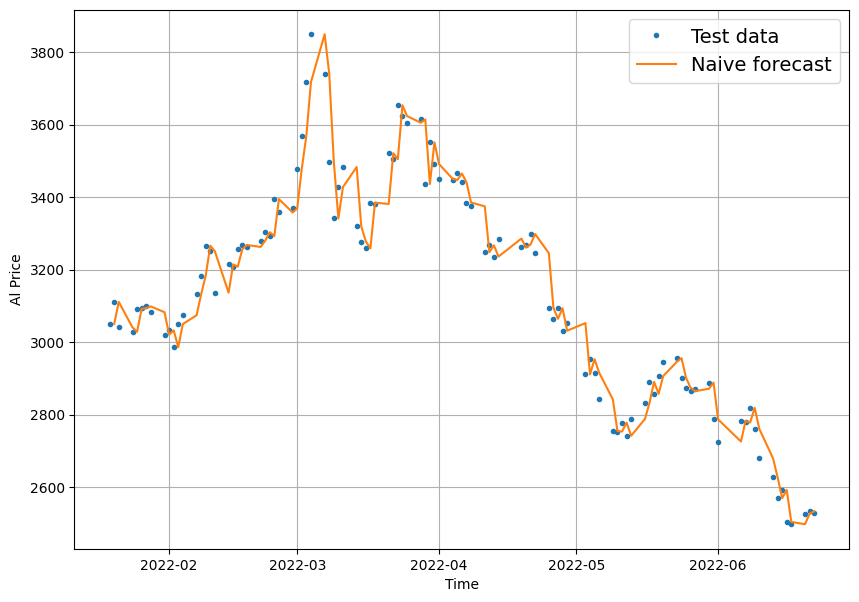

In [15]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

### LSTM Aproach

In [16]:
# Built, train and evaluate Vanilla LSTM model

vanilla_model = Sequential()
vanilla_model.add(LSTM(100, activation='relu', kernel_initializer = HeNormal(42), input_shape=(WINDOW_SIZE, 1)))
vanilla_model.add(Dense(1))
vanilla_model.compile(optimizer='adam', loss='mse')
vanilla_model.fit(train_windows, train_labels, epochs=500, verbose=0)
vanilla_model_preds = make_preds(vanilla_model, test_windows)
vanilla_model_results = evaluate_pred(y_true=tf.squeeze(test_labels), y_pred=vanilla_model_preds)
vanilla_model_results

13/13 [==============================] - 0s 2ms/step


{'mae': 34.78579,
 'mse': 2359.0076,
 'rmse': 48.569614,
 'mape': 1.2752658,
 'mase': 1.016525}

In [17]:
# Built, train and evaluate Stacked LSTM model

stacked_model = Sequential()
stacked_model.add(LSTM(100, activation='relu', kernel_initializer = HeNormal(42), return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
stacked_model.add(LSTM(100, activation='relu', kernel_initializer = HeNormal(7)))
stacked_model.add(Dense(1))
stacked_model.compile(optimizer='adam', loss='mse')
stacked_model.fit(train_windows, train_labels, epochs=500, verbose=0)
stacked_model_preds = make_preds(stacked_model, test_windows)
stacked_model_results = evaluate_pred(y_true=tf.squeeze(test_labels), y_pred=stacked_model_preds)
stacked_model_results

13/13 [==============================] - 0s 4ms/step


{'mae': 34.03849,
 'mse': 2303.946,
 'rmse': 47.99944,
 'mape': 1.2460546,
 'mase': 0.99468714}

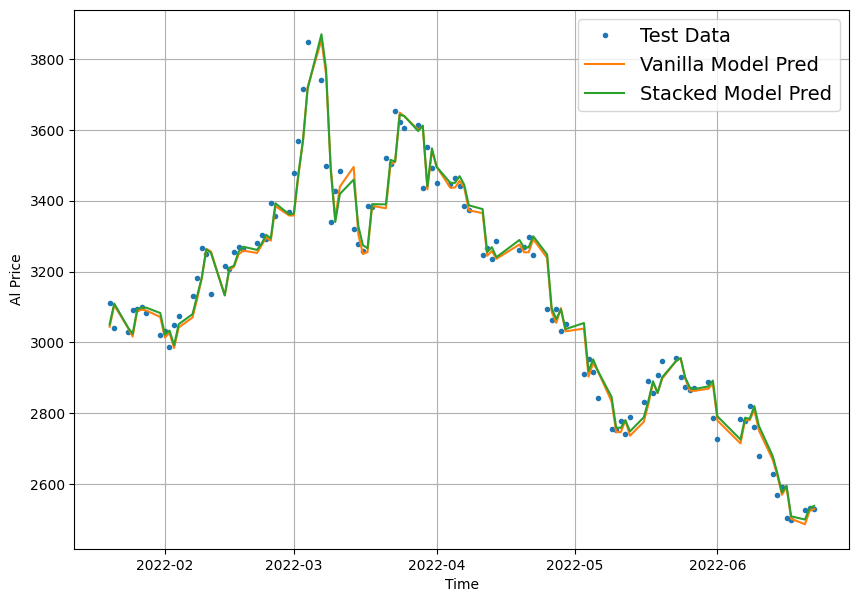

In [18]:
offset = 300
plt.figure(figsize=(10, 7))
 
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=vanilla_model_preds, start=offset, format="-", label="Vanilla Model Pred")
plot_time_series(timesteps=X_test[-len(test_windows):], values=stacked_model_preds, start=offset, format="-", label="Stacked Model Pred")

In [19]:
# Built, train and evaluate Vanilla LSTM model with 250 units

vanilla250_model = Sequential()
vanilla250_model.add(LSTM(250, activation='relu', kernel_initializer = HeNormal(42), input_shape=(WINDOW_SIZE, 1)))
vanilla250_model.add(Dense(1))
vanilla250_model.compile(optimizer='adam', loss='mse')
vanilla250_model.fit(train_windows, train_labels, epochs=500, verbose=0)
vanilla250_model_preds = make_preds(vanilla250_model, test_windows)
vanilla250_model_results = evaluate_pred(y_true=tf.squeeze(test_labels), y_pred=vanilla250_model_preds)
vanilla250_model_results

13/13 [==============================] - 0s 2ms/step


{'mae': 34.671776,
 'mse': 2450.9902,
 'rmse': 49.507477,
 'mape': 1.2699987,
 'mase': 1.0131932}

In [20]:
# Built, train and evaluate Stacked LSTM model with 250 units each

stacked250_model = Sequential()
stacked250_model.add(LSTM(250, activation='relu', kernel_initializer = HeNormal(42), return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
stacked250_model.add(LSTM(250, activation='relu', kernel_initializer = HeNormal(7)))
stacked250_model.add(Dense(1))
stacked250_model.compile(optimizer='adam', loss='mse')
stacked250_model.fit(train_windows, train_labels, epochs=500, verbose=0)
stacked250_model_preds = make_preds(stacked250_model, test_windows)
stacked250_model_results = evaluate_pred(y_true=tf.squeeze(test_labels), y_pred=stacked250_model_preds)
stacked250_model_results

13/13 [==============================] - 0s 4ms/step


{'mae': 64.57468,
 'mse': 7568.8394,
 'rmse': 86.99908,
 'mape': 2.3409185,
 'mase': 1.8870285}

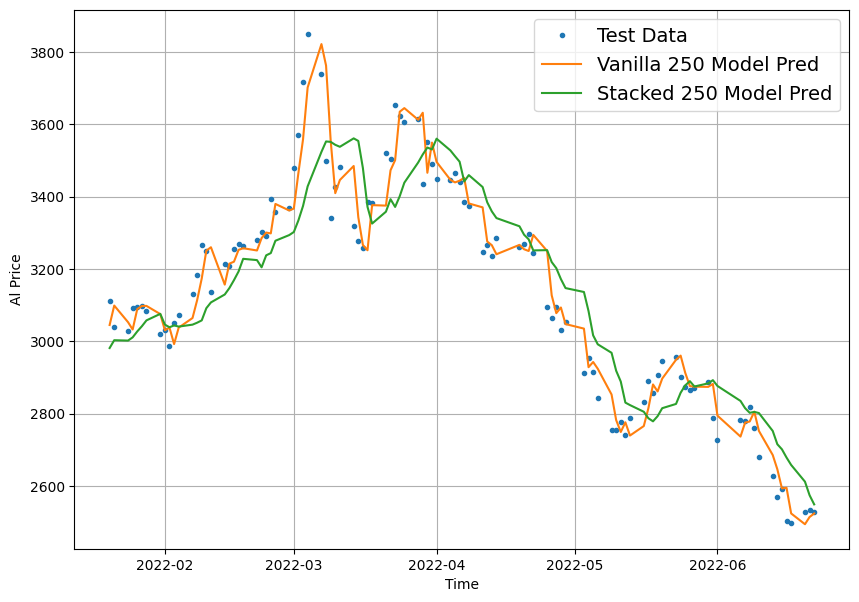

In [21]:
offset = 300
plt.figure(figsize=(10, 7))
 
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=vanilla250_model_preds, start=offset, format="-", label="Vanilla 250 Model Pred")
plot_time_series(timesteps=X_test[-len(test_windows):], values=stacked250_model_preds, start=offset, format="-", label="Stacked 250 Model Pred")

In [89]:
## Make a Table with the results

all_model_results = [naive_results, vanilla_model_results, stacked_model_results, vanilla250_model_results, stacked250_model_results]
left_rule = {'<': ':', '^': ':', '>': '-'}
right_rule = {'<': '-', '^': ':', '>': ':'}

def makeDataforTable(model_results):
    data = []
    model_names = ['Naive Forecast', 'Vanilla LSTM', 'Stacked LSTM', 'Vanilla 250 LSTM', 'Stacked 250 LSTM']
    i = 0
    for result in model_results:
        metrics = list(result.values())
        metrics.append(model_names[i])
        metrics = tuple(metrics)
        data.append(metrics)
        i+=1
    return data

def evalute_field(record, field_spec):
    """
    Evalute a field of a record using the type of the field_spec as a guide.
    """
    if type(field_spec) is int:
        return str(record[field_spec])
    elif type(field_spec) is str:
        return str(getattr(record, field_spec))
    else:
        return str(field_spec(record))

def table(file, records, fields, headings, alignment = None):
    """
    Generate a Doxygen-flavor Markdown table from records.

    file -- Any object with a 'write' method that takes a single string
        parameter.
    records -- Iterable.  Rows will be generated from this.
    fields -- List of fields for each row.  Each entry may be an integer,
        string or a function.  If the entry is an integer, it is assumed to be
        an index of each record.  If the entry is a string, it is assumed to be
        a field of each record.  If the entry is a function, it is called with
        the record and its return value is taken as the value of the field.
    headings -- List of column headings.
    alignment - List of pairs alignment characters.  The first of the pair
        specifies the alignment of the header, (Doxygen won't respect this, but
        it might look good, the second specifies the alignment of the cells in
        the column.

        Possible alignment characters are:
            '<' = Left align (default for cells)
            '>' = Right align
            '^' = Center (default for column headings)
    """

    num_columns = len(fields)
    assert len(headings) == num_columns

    # Compute the table cell data
    columns = [[] for i in range(num_columns)]
    for record in records:
        for i, field in enumerate(fields):
            columns[i].append(evalute_field(record, field))

    # Fill out any missing alignment characters.
    extended_align = alignment if alignment != None else []
    if len(extended_align) > num_columns:
        extended_align = extended_align[0:num_columns]
    elif len(extended_align) < num_columns:
        extended_align += [('^', '<')
                           for i in range[num_columns-len(extended_align)]]

    heading_align, cell_align = [x for x in zip(*extended_align)]

    field_widths = [len(max(column, key=len)) if len(column) > 0 else 0
                    for column in columns]
    heading_widths = [max(len(head), 2) for head in headings]
    column_widths = [max(x) for x in zip(field_widths, heading_widths)]

    _ = ' | '.join(['{:' + a + str(w) + '}'
                    for a, w in zip(heading_align, column_widths)])
    heading_template = '| ' + _ + ' |'
    _ = ' | '.join(['{:' + a + str(w) + '}'
                    for a, w in zip(cell_align, column_widths)])
    row_template = '| ' + _ + ' |'

    _ = ' | '.join([left_rule[a] + '-'*(w-2) + right_rule[a]
                    for a, w in zip(cell_align, column_widths)])
    ruling = '| ' + _ + ' |'

    file.write(heading_template.format(*headings).rstrip() + '\n')
    file.write(ruling.rstrip() + '\n')
    for row in zip(*columns):
        file.write(row_template.format(*row).rstrip() + '\n')

data = makeDataforTable(all_model_results)

import sys

sys.stdout.write('Naive Forecast x LSTM Models - Metrics Comparison\n\n')

headings = ['MODEL', 'MAE.', 'MSE', 'RMSE', 'MAPE', 'MASE']
fields = [5, 0, 1, 2, 3, 4]

align = [('^', '<'), ('^', '^'), ('^', '<'), ('^', '^'), ('^', '>'),
         ('^','^')]

table(sys.stdout, data, fields, headings, align)

Naive Forecast x LSTM Models - Metrics Comparison

|      MODEL       |   MAE.    |    MSE    |   RMSE    |   MAPE    |    MASE    |
| :--------------- | :-------: | :-------- | :-------: | --------: | :--------: |
| Naive Forecast   | 34.160492 | 2278.5    | 47.733635 | 1.2517097 | 0.9982523  |
| Vanilla LSTM     | 34.78579  | 2359.0076 | 48.569614 | 1.2752658 |  1.016525  |
| Stacked LSTM     | 34.03849  | 2303.946  | 47.99944  | 1.2460546 | 0.99468714 |
| Vanilla 250 LSTM | 34.671776 | 2450.9902 | 49.507477 | 1.2699987 | 1.0131932  |
| Stacked 250 LSTM | 64.57468  | 7568.8394 | 86.99908  | 2.3409185 | 1.8870285  |
